In [1]:
import pandas as pd

In [2]:
df = pd.read_json("s3a://udacity-dsnd/sparkify/mini_sparkify_event_data.json", lines=True)

In [3]:
df.head()

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
0,1538352117000,30,29,NextSong,Logged In,PUT,200,paid,50,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Martha Tilston,Rockpools,277.89016
1,1538352180000,9,8,NextSong,Logged In,PUT,200,free,79,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Five Iron Frenzy,Canada,236.09424
2,1538352394000,30,29,NextSong,Logged In,PUT,200,paid,51,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Adam Lambert,Time For Miracles,282.82730
3,1538352416000,9,8,NextSong,Logged In,PUT,200,free,80,"Boston-Cambridge-Newton, MA-NH","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Long,Micah,1.538332e+12,M,Enigma,Knocking On Forbidden Doors,262.71302
4,1538352676000,30,29,NextSong,Logged In,PUT,200,paid,52,"Bakersfield, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Freeman,Colin,1.538173e+12,M,Daft Punk,Harder Better Faster Stronger,223.60771


## Exploration

In [4]:
df["userId"].nunique()

226

Filter out users who are not logged in. We only care about churn so we focus our analysis on users that already have an account

In [5]:
df = df[df["userId"] != ""]

If the user has visited the Cancellation Confirmation page, they have left the platform

In [25]:
churned = df.groupby("userId")["page"].unique() \
    .map(lambda x: 1 if "Cancellation Confirmation" in x else 0)

In [6]:
sessions_per_user = df.groupby("userId")["sessionId"].nunique()

In [7]:
session_len = df.groupby(['userId', "sessionId"]).agg({"ts": ['min', 'max']})

In [8]:
session_len["length"] = session_len[('ts', 'max')] - session_len[('ts', 'min')]

In [9]:
session_len

ts                   length
                            min            max          
userId sessionId                                        
10     9          1538965220000  1538979372000  14152000
       595        1539833923000  1539926798000  92875000
       1047       1540850546000  1540856031000   5485000
       1414       1541255262000  1541270598000  15336000
       1592       1542310466000  1542327989000  17523000
...                         ...            ...       ...
99     1683       1542376407000  1542389629000  13222000
       2011       1542585085000  1542590831000   5746000
       2062       1542900850000  1542918384000  17534000
       2201       1543067431000  1543095650000  28219000
       2274       1543275474000  1543303277000  27803000

[3176 rows x 3 columns]

In [26]:
import seaborn as sns

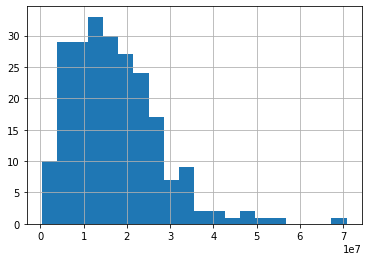

In [10]:
session_len.groupby("userId")["length"].mean().hist(bins=20);

In [11]:
avg_session_len_per_user = session_len.groupby("userId")["length"].mean()

In [12]:
avg_session_len_per_user

userId
10        2.758483e+07
100       1.899114e+07
100001    8.889500e+06
100002    1.207100e+07
100003    5.947000e+06
              ...     
95        1.269688e+07
96        2.354216e+07
97        1.609980e+07
98        2.223082e+07
99        1.142982e+07
Name: length, Length: 225, dtype: float64

In [37]:
churned_len = pd.concat([churned, avg_session_len_per_user], axis=1)
churned_len.columns = ["Churned", "Session Length"]

In [35]:
import matplotlib.pyplot as plt

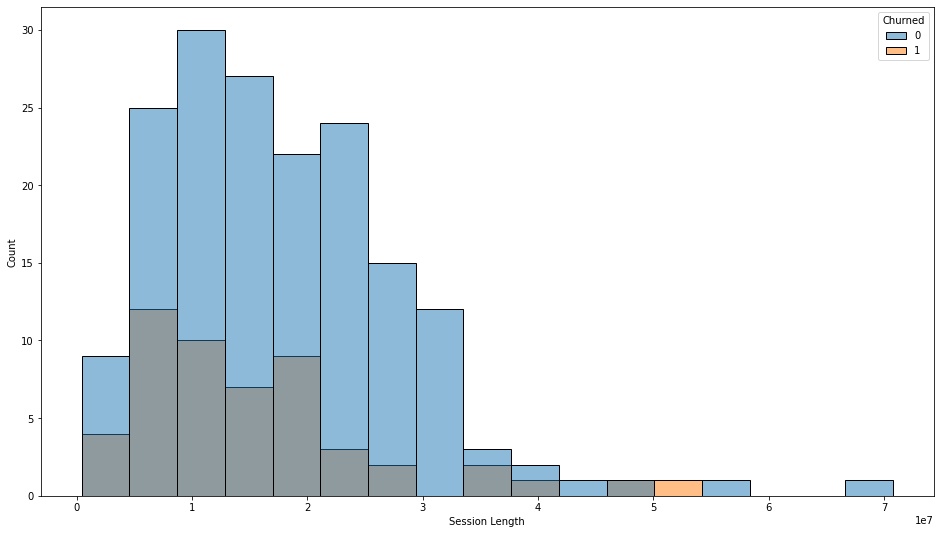

In [38]:
plt.figure(figsize=(16,9))
sns.histplot(churned_len, x="Session Length", hue="Churned");

There is no clear difference in session time between churned and not churned users.

In [13]:
session_ends = df.sort_values("ts").groupby(["userId", "sessionId"])[["ts", "itemInSession"]].last()

In [14]:
session_ends

ts  itemInSession
userId sessionId                              
10     9          1538979372000             71
       595        1539926798000            456
       1047       1540856031000             24
       1414       1541270598000             81
       1592       1542327989000             83
...                         ...            ...
99     1683       1542389629000             55
       2011       1542590831000             23
       2062       1542918384000             91
       2201       1543095650000            148
       2274       1543303277000            136

[3176 rows x 2 columns]

In [15]:
avg_time_bw_sessions = session_ends.sort_values('ts').groupby("userId")['ts'].agg(lambda x: x.diff().mean())

In [16]:
avg_time_bw_sessions[:10]

userId
10        7.304832e+08
100       1.487741e+08
100001    3.737400e+07
100002    1.586523e+09
100003    1.741680e+08
100004    2.459878e+08
100005    3.888878e+08
100006             NaN
100007    6.250461e+08
100008    8.457060e+08
Name: ts, dtype: float64

In [17]:
avg_time_bw_sessions.mean()

487043744.5645679

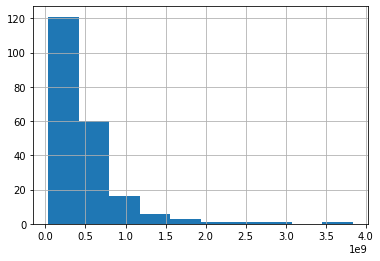

In [18]:
avg_time_bw_sessions.hist();

In [19]:
avg_time_bw_sessions.isna().sum()

15

In [20]:
df["page"].unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

In [21]:
df["auth"].unique()

array(['Logged In', 'Cancelled'], dtype=object)

In [22]:
df[df["page"] == "Cancellation Confirmation"]

,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
20231,1538943990000,18,514,Cancellation Confirmation,Cancelled,GET,200,paid,104,"Kansas City, MO-KS","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Mendoza,Adriel,1.535623e+12,M,NaN,NaN,NaN
23811,1539033046000,32,540,Cancellation Confirmation,Cancelled,GET,200,paid,56,"Phoenix-Mesa-Scottsdale, AZ","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",Mckee,Diego,1.537168e+12,M,NaN,NaN,NaN
37817,1539318918000,125,174,Cancellation Confirmation,Cancelled,GET,200,free,10,"Corpus Christi, TX","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Hart,Mason,1.533157e+12,M,NaN,NaN,NaN
40356,1539375441000,105,508,Cancellation Confirmation,Cancelled,GET,200,paid,332,"Indianapolis-Carmel-Anderson, IN",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,Garcia,Alexander,1.536817e+12,M,NaN,NaN,NaN
42009,1539465584000,17,797,Cancellation Confirmation,Cancelled,GET,200,paid,273,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,Johnson,Kayla,1.538334e+12,F,NaN,NaN,NaN
44616,1539588854000,143,843,Cancellation Confirmation,Cancelled,GET,200,free,29,"Virginia Beach-Norfolk-Newport News, VA-NC","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",Harrison,Molly,1.534255e+12,F,NaN,NaN,NaN
52748,1539729037000,101,842,Cancellation Confirmation,Cancelled,GET,200,paid,145,"Denver-Aurora-Lakewood, CO",Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) G...,Hogan,Alex,1.535066e+12,M,NaN,NaN,NaN
53205,1539736161000,129,802,Cancellation Confirmation,Cancelled,GET,200,paid,34,"Flint, MI","""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",Wang,Davis,1.538290e+12,M,NaN,NaN,NaN
54476,1539759749000,121,881,Cancellation Confirmation,Cancelled,GET,200,paid,287,"Oxnard-Thousand Oaks-Ventura, CA",Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:31....,Olsen,Nikolas,1.528404e+12,M,NaN,NaN,NaN
54619,1539761972000,51,934,Cancellation Confirmation,Cancelled,GET,200,paid,176,"Lexington-Fayette, KY","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",Johnson,Ethan,1.538081e+12,M,NaN,NaN,NaN


## Create main dataframe

In [39]:
user_info = pd.DataFrame({"avg_time_bw_sessions": avg_time_bw_sessions})

In [40]:
user_info["avg_session_length"] = avg_session_len_per_user

In [41]:
user_info.head()

,avg_time_bw_sessions,avg_session_length
userId,,
10,7.304832e+08,2.758483e+07
100,1.487741e+08,1.899114e+07
100001,3.737400e+07,8.889500e+06
100002,1.586523e+09,1.207100e+07
100003,1.741680e+08,5.947000e+06


In [42]:
user_info.isna().sum()

avg_time_bw_sessions    15
avg_session_length       0
dtype: int64

Check format of ts, looks to be in milliseconds since epoch

In [43]:
df["ts"].iloc[0]

1538352117000

In [44]:
def days(series):
    first = series.iloc[0]
    last = series.iloc[-1]
    return max(1, round((last - first) / 3600 / 24 / 1000, 2))

In [45]:
days_on_platform = df.sort_values("ts").groupby("userId").agg({"ts": days})

In [46]:
user_info["days_on_platform"] = days_on_platform

In [47]:
user_info.isna().sum()

avg_time_bw_sessions    15
avg_session_length       0
days_on_platform         0
dtype: int64

In [48]:
user_info["total_pages"] = df.groupby("userId")['ts'].count()

In [49]:
user_info.isna().sum()

avg_time_bw_sessions    15
avg_session_length       0
days_on_platform         0
total_pages              0
dtype: int64

In [50]:
user_info["pages_per_day"] = user_info.apply(lambda x: x["total_pages"] / x["days_on_platform"], axis=1)

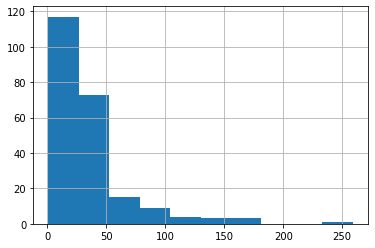

In [51]:
user_info["pages_per_day"].hist();

In [52]:
user_info.isna().sum()

avg_time_bw_sessions    15
avg_session_length       0
days_on_platform         0
total_pages              0
pages_per_day            0
dtype: int64

In [53]:
page_visits = df.groupby("userId")["page"].value_counts().unstack()

In [54]:
page_visits = page_visits.fillna(0)

In [60]:
page_visits = df.groupby("userId")["page"].value_counts().unstack()
page_visits = page_visits.fillna(0)
page_visits.head()

page,About,Add Friend,Add to Playlist,Cancel,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
userId,,,,,,,,,,,,,,,,,,,
10,2.0,12.0,9.0,0.0,0.0,7.0,0.0,1.0,30.0,11.0,673.0,1.0,1.0,7.0,0.0,0.0,4.0,37.0,0.0
100,12.0,49.0,61.0,0.0,0.0,30.0,3.0,18.0,105.0,35.0,2682.0,25.0,5.0,11.0,1.0,1.0,27.0,148.0,1.0
100001,0.0,2.0,3.0,1.0,1.0,0.0,1.0,1.0,11.0,7.0,133.0,14.0,0.0,1.0,0.0,0.0,2.0,8.0,2.0
100002,0.0,1.0,5.0,0.0,0.0,2.0,0.0,0.0,6.0,1.0,195.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
100003,0.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,7.0,3.0,51.0,9.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


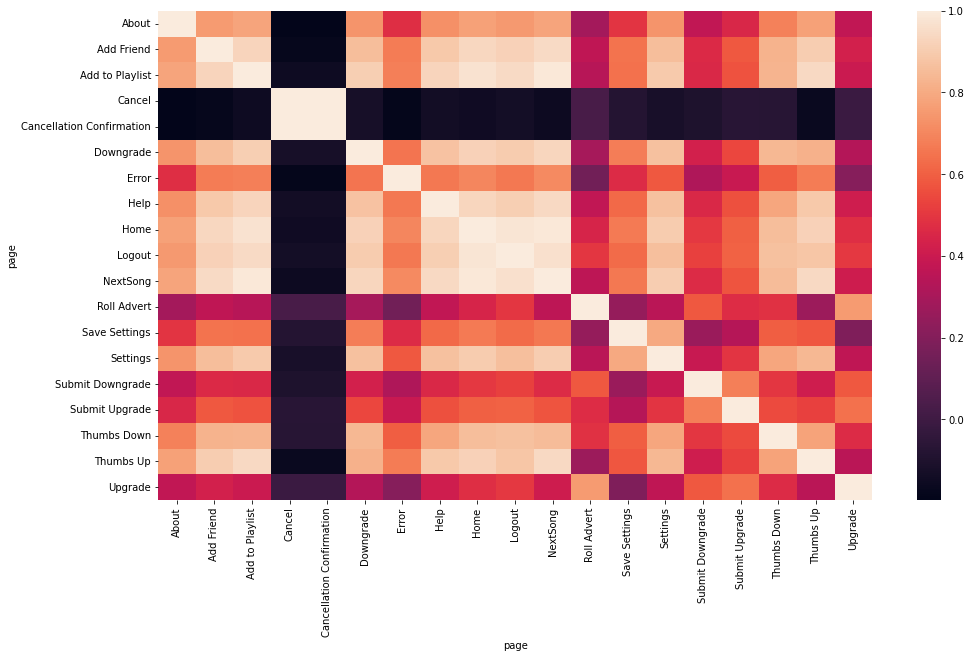

In [62]:
plt.figure(figsize=(16,9))
sns.heatmap(page_visits.corr());

In [56]:
user_info.index

Index(['10', '100', '100001', '100002', '100003', '100004', '100005', '100006',
       '100007', '100008',
       ...
       '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype='object', name='userId', length=225)

In [57]:
user_info = user_info.merge(page_visits, on="userId")

In [58]:
user_info.shape

(225, 24)

In [59]:
user_info.isna().sum()

avg_time_bw_sessions         15
avg_session_length            0
days_on_platform              0
total_pages                   0
pages_per_day                 0
About                         0
Add Friend                    0
Add to Playlist               0
Cancel                        0
Cancellation Confirmation     0
Downgrade                     0
Error                         0
Help                          0
Home                          0
Logout                        0
NextSong                      0
Roll Advert                   0
Save Settings                 0
Settings                      0
Submit Downgrade              0
Submit Upgrade                0
Thumbs Down                   0
Thumbs Up                     0
Upgrade                       0
dtype: int64

Let's train a baseline LogisticRegression just to see what happens

In [205]:
X = user_info.drop(columns=["Cancellation Confirmation", "Cancel", "avg_time_bw_sessions"])
y = user_info["Cancellation Confirmation"]

In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [208]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [209]:
from sklearn.metrics import classification_report
preds = log_reg.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.72      1.00      0.84        49
         1.0       0.00      0.00      0.00        19

    accuracy                           0.72        68
   macro avg       0.36      0.50      0.42        68
weighted avg       0.52      0.72      0.60        68



/home/greg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/greg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/greg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Not so great since we have such a small sample size and very low number of churned users in general. Let's try some other modeling approaches.

In [210]:
from sklearn.ensemble import RandomForestClassifier

In [211]:
forest = RandomForestClassifier(n_estimators=1000, max_depth=10)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [212]:
preds = forest.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87        49
         1.0       0.78      0.37      0.50        19

    accuracy                           0.79        68
   macro avg       0.79      0.66      0.69        68
weighted avg       0.79      0.79      0.77        68



In [213]:
49/68

0.7205882352941176

We have a slightly better accuracy than just predicting the most common class. Maybe a gridsearch could get us closer.

In [214]:
from sklearn.model_selection import GridSearchCV

In [215]:
params = {
    "max_depth": [2, 5, 10, 20],
    "min_samples_split": [2,4,6]
}

cv = GridSearchCV(forest, params)

In [216]:
cv.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(max_depth=10, n_estimators=1000),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'min_samples_split': [2, 4, 6]})

In [217]:
cv.best_params_

{'max_depth': 5, 'min_samples_split': 4}

In [218]:
forest_2 = RandomForestClassifier(**cv.best_params_)

In [219]:
forest_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_split=4)

In [238]:
threshold = 0.27
preds = forest_2.predict_proba(X_test)
print(classification_report(y_test, preds[:, 1] > threshold))

              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88        49
         1.0       0.67      0.84      0.74        19

    accuracy                           0.84        68
   macro avg       0.80      0.84      0.81        68
weighted avg       0.86      0.84      0.84        68



Now that we have a decent model on a subset of the dataset, we can convert our code into PySpark code and run it on a cluster on AWS.